<a href="https://colab.research.google.com/github/Umang1103/Literature-Skimmer/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit📖📗🔥

This notebook aims at creating an NLP model that classifies abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit) and dive deeper when necessary.

## Importing libraries and modules


In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-03 08:35:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-03 08:35:59 (94.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import string

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from helper_functions import calculate_results
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
import tensorflow_hub as hub

## Confirm access to GPU

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-16df5bd1-20b6-caf5-8bd8-585cbbe35112)


## Get the data
Since we'll be replicating the paper (PubMed 200k RCT), let's download the dataset.

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [6]:
# Check what files are in the PubMed_20k_ dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [7]:
# We'll start our experiment using the 20k dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [8]:
# Path to all the files in data_dir
filenames = [data_dir+path for path in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Data Preprocessing

In [9]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename) as f:
    return f.readlines()

In [10]:
train_lines = get_lines(data_dir+"train.txt")
len(train_lines), train_lines[:10]

(210040,
 ['###24293578\n',
  'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
  'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
  'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor 

In [11]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [12]:
# Get the data from the file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 417 ms, sys: 67.1 ms, total: 484 ms
Wall time: 485 ms


In [13]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Let's convert the dictionary into a dataframe and try to visualize it.

In [14]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.sample(5)

,target,text,line_number,total_lines
131943,RESULTS,women and men had similar as progression rate ...,6,12
106485,BACKGROUND,methylphenidate is considered to improve atten...,2,13
133377,CONCLUSIONS,"analgesics , opioid .",12,15
125626,RESULTS,significantly more czp patients met the primar...,4,12
67459,RESULTS,patients being iron-deficient at enrolment ( @...,7,12


In [15]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

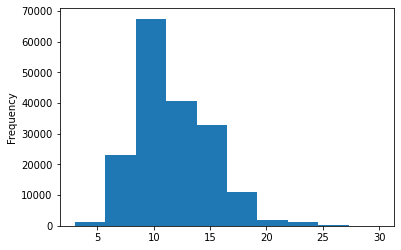

In [16]:
train_df["total_lines"].plot.hist();

## Get lists of sentences

#### One-hot encoding labels

In [17]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
train_labels = train_df['target'].to_list()
val_labels = val_df['target'].to_list()
test_labels = test_df['target'].to_list()

In [18]:
# Convert our data labels in numeric format
onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)
train_labels_one_hot = onehot.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = onehot.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = onehot.transform(test_df['target'].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
val_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

#### Label Encoding labels

In [20]:
enc = LabelEncoder()
train_labels = enc.fit_transform(train_df['target'].to_numpy())
val_labels = enc.transform(val_df['target'].to_numpy())
val_labels[:5]

array([0, 0, 3, 2, 2])

In [21]:
# Get class names and no. of classes from LabelEncoder instance
num_classes = len(enc.classes_)
classes = enc.classes_
num_classes, classes

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating and Fitting Models

### Model 0 : Baseline Model - Naive bayes

In [22]:
# Create a model pipeline
model_0 = Pipeline([
      ("tf-idf", TfidfVectorizer()),
      ("clf", MultinomialNB())
])

# Evaluate the model on validation dataset
model_0_history = model_0.fit(X=train_sentences,
                              y=train_labels);

In [26]:
#Evaluate the model on validation dataset
score_0 = model_0.score(X=val_sentences,y=val_labels);
score_0

0.7218323844829869

In [27]:
# Predicting on the validation dataset
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:5]

array([4, 1, 3, 2, 2])

Get the helper function script where `calculate_result` will help us determine the:
* Precision
* Accuracy
* Recall
* F1-score

In [28]:
baseline_result = calculate_results(y_true=val_labels,
                                    y_pred=baseline_preds)
baseline_result

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Model 1: Conv1D with token embeddings

#### TextVectorization Layer

In [29]:
# Find the average number of tokens (words) in the training tweets
sent_lens = [len(sentence.split()) for sentence in train_sentences]

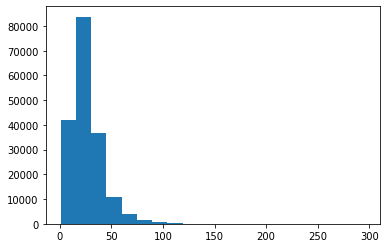

In [30]:
plt.hist(sent_lens, bins=20);

In [31]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [32]:
# Setting the text-vectorizer
max_vocab_length = 68000  # max no. of words to have in our vocabulary
max_length = 55

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=max_length,
                                    output_mode="int")

In [33]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Get the unique words in the vocabulary

# Get all the unique words in the training data
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
last_5_words = words_in_vocab[-5:]
print("Most common words: ", top_5_words)
print("Least common words: ", last_5_words)

Most common words:  ['', '[UNK]', 'the', 'and', 'of']
Least common words:  ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

#### Embedding Layer

In [36]:
# Creating an embedding layer
embedding = layers.Embedding(input_dim=max_vocab_length,  # set input shape
                             output_dim=128,  # output shape
                             mask_zero=True,  # use masking to handle variable sequence lengths
                             name="embedding")
embedding

#### Create datasets (as fast as possible)

We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the tf.data API provides methods which enable faster data loading.

The main steps we'll want to use with our data is to turn it into a `PrefetchDataset` of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched `PrefetchDataset` we can use the methods `batch()` and `prefetch()`, the parameter `tf.data.AUTOTUNE` will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [37]:
# Train our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [38]:
# Take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [39]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#### Creating the CNN model

In [40]:
# Create conv1D model
input = layers.Input(shape=(1, ), dtype="string")
x = text_vectorizer(input)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  padding='same',
                  activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
output = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(input, output, name="model_1")

In [41]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325 

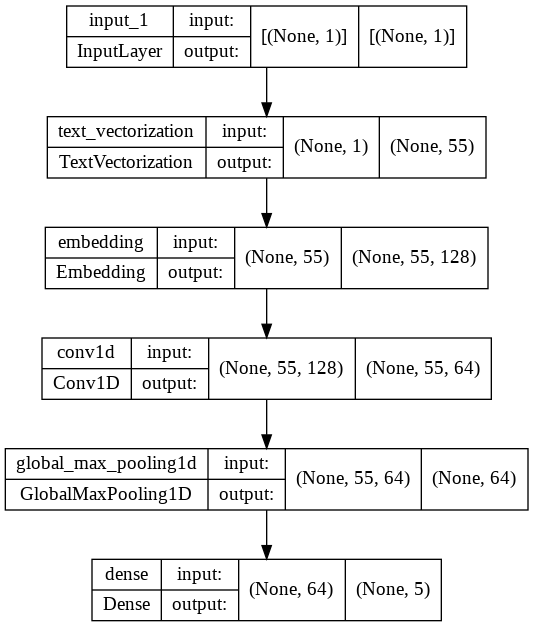

In [42]:
# Plot hybrid token and character model
plot_model(model_1, show_shapes=True)

In [43]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=['accuracy'])

# Fit the model
mode1_1_history = model_1.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 17s 9ms/step - loss: 0.8409 - accuracy: 0.6831 - val_loss: 0.5924 - val_accuracy: 0.7842
Epoch 2/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5785 - accuracy: 0.7901 - val_loss: 0.5419 - val_accuracy: 0.8005
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5438 - accuracy: 0.8009 - val_loss: 0.5225 - val_accuracy: 0.8118
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5258 - accuracy: 0.8068 - val_loss: 0.5236 - val_accuracy: 0.8025
Epoch 5/5
562/562 [==============================] - 6s 11ms/step - loss: 0.5300 - accuracy: 0.8073 - val_loss: 0.4988 - val_accuracy: 0.8145


In [44]:
# Evaluate on the validation dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.4966 - accuracy: 0.8178


[0.4965721666812897, 0.8177876472473145]

In [45]:
# Make predictions on our model
model_1_preds = model_1.predict(val_dataset)

In [46]:
model_1_preds, model_1_preds.shape

(array([[4.7119585e-01, 2.6861605e-01, 4.3154862e-03, 2.4600358e-01,
         9.8690474e-03],
        [5.3295130e-01, 3.0623710e-01, 2.5434776e-03, 1.4443614e-01,
         1.3832051e-02],
        [2.3751281e-01, 2.8894838e-02, 1.4446435e-02, 7.1829695e-01,
         8.4900041e-04],
        ...,
        [5.0818920e-04, 2.0906746e-03, 3.2578662e-02, 6.7907415e-04,
         9.6414346e-01],
        [2.3845522e-02, 6.7343676e-01, 1.8566657e-02, 1.2533271e-02,
         2.7161774e-01],
        [7.3127173e-02, 9.1407949e-01, 7.0155850e-03, 2.7204982e-03,
         3.0572659e-03]], dtype=float32), (30212, 5))

The index of the maximum value is the index of the label in the classes list.

In [47]:
model_1_preds = tf.argmax(model_1_preds, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 81.77876340526943,
 'precision': 0.8197179560685938,
 'recall': 0.8177876340526943,
 'f1': 0.8154719666143714}

In [49]:
baseline_result

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Model 2: Feature Extraction with pretrained token embeddings

In [50]:
# Download pretrained TensorFlow Hub USE
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='univeral_sentence_encoder')

In [51]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence:\n {random_train_sentence}')
use_embed_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n {use_embed_sentence}')

Random sentence:
 oprm@ genotype was found to moderate these relationships .
Sentence after embedding:
 [[ 5.67446090e-02  5.03788143e-02 -3.15840840e-02  7.08303154e-02
   2.94910092e-02  6.31572902e-02  2.62733195e-02 -1.02753164e-02
  -7.57073238e-02  7.46222958e-02  5.05183637e-02  3.71758454e-02
  -2.71489248e-02 -3.88844823e-03  1.14610484e-02 -8.10952783e-02
  -8.37372690e-02 -6.05727406e-03  1.96302473e-03  8.23717937e-03
  -2.61191186e-02  4.43385057e-02  2.80836690e-02  1.72798894e-03
   1.20348232e-02 -1.78143159e-02  5.80181740e-02 -4.46014367e-02
   5.92625365e-02  6.52758405e-02 -1.47304265e-03  1.99890472e-02
  -2.40483936e-02 -1.59081612e-02 -7.75294006e-02  5.95829375e-02
  -5.45930937e-02 -2.48144772e-02  3.10097933e-02  5.68232276e-02
  -6.36395067e-02  4.15636748e-02  3.84511761e-02  4.41880785e-02
   5.76821044e-02  6.03561215e-02  1.12957903e-03 -7.62850558e-03
   5.18306792e-02  1.52557380e-02  4.20832122e-03  2.79997494e-02
  -3.36706825e-03 -6.77706897e-02  6.7

#### Creating and fitting the model

In [52]:
# Instantiate the model
model_2 = tf.keras.Sequential([
      layers.Input(shape=(), dtype='string'),                         
      tf_hub_embedding_layer,
      layers.Dense(256, activation="relu"),
      layers.Dense(num_classes, activation="softmax")
], name="universal_sentence_encoder_use")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer='Adam',
                metrics=["accuracy"])

# Fit the model
model_2_history = model_2.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 10s 14ms/step - loss: 0.8873 - accuracy: 0.6584 - val_loss: 0.7853 - val_accuracy: 0.6941
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7543 - accuracy: 0.7072 - val_loss: 0.7366 - val_accuracy: 0.7144
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7299 - accuracy: 0.7218 - val_loss: 0.7137 - val_accuracy: 0.7247
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.6954 - accuracy: 0.7356 - val_loss: 0.6855 - val_accuracy: 0.7414
Epoch 5/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7025 - accuracy: 0.7287 - val_loss: 0.6681 - val_accuracy: 0.7427


In [53]:
model_2.summary()

Model: "universal_sentence_encoder_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 univeral_sentence_encoder (  (None, 512)              256797824 
 KerasLayer)                                                     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 256,930,437
Trainable params: 132,613
Non-trainable params: 256,797,824
_________________________________________________________________


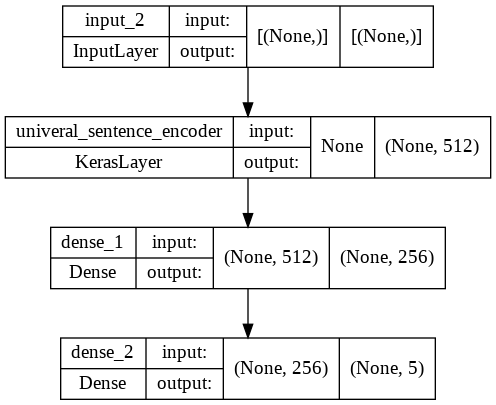

In [54]:
# Plot hybrid token and character model
plot_model(model_2, show_shapes=True)

In [55]:
# Evaluate the model
model_2.evaluate(val_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.6756 - accuracy: 0.7432


[0.6755797266960144, 0.7432146072387695]

In [56]:
# make predictions with feature extraction model
model_2_preds = model_2.predict(val_dataset)
model_2_preds

array([[6.8416196e-01, 1.8900725e-01, 1.3476452e-03, 1.1854238e-01,
        6.9406829e-03],
       [4.5419374e-01, 4.4958973e-01, 5.5068773e-03, 8.8908307e-02,
        1.8013400e-03],
       [3.8692865e-01, 5.4975670e-02, 5.6353379e-02, 4.6011046e-01,
        4.1631866e-02],
       ...,
       [1.1132361e-03, 9.4166980e-04, 5.8922287e-02, 2.7548798e-04,
        9.3874729e-01],
       [2.5503915e-03, 2.5620943e-02, 4.5839393e-01, 8.2379871e-04,
        5.1261097e-01],
       [1.4168599e-01, 5.7151043e-01, 2.5309056e-01, 2.0669766e-03,
        3.1646013e-02]], dtype=float32)

In [57]:
# Covert the prediction to class labels
model_2_preds = tf.argmax(model_2_preds, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [58]:
# Performance metrics for model 2
model_2_results = calculate_results(y_true=val_labels,
                                   y_pred=model_2_preds)
model_2_results

{'accuracy': 74.32146167085925,
 'precision': 0.7392475921248868,
 'recall': 0.7432146167085926,
 'f1': 0.7375015101709445}

### Model 3: Conv1D with character embeddings

In [59]:
random_sentence = random.choice(train_sentences)
random_sentence

'one hundred thirty patients will be randomly allocated into either the intervention or placebo group at a ratio of @:@ .'

In [60]:
' '.join(list(random_sentence))

'o n e   h u n d r e d   t h i r t y   p a t i e n t s   w i l l   b e   r a n d o m l y   a l l o c a t e d   i n t o   e i t h e r   t h e   i n t e r v e n t i o n   o r   p l a c e b o   g r o u p   a t   a   r a t i o   o f   @ : @   .'

In [61]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_sentence)

'o n e   h u n d r e d   t h i r t y   p a t i e n t s   w i l l   b e   r a n d o m l y   a l l o c a t e d   i n t o   e i t h e r   t h e   i n t e r v e n t i o n   o r   p l a c e b o   g r o u p   a t   a   r a t i o   o f   @ : @   .'

In [62]:
# Split sequence-level data into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [63]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [64]:
# What's the average charcter length?
char_len = [len(i) for i in train_sentences]
average_char_len = np.mean(char_len)
average_char_len

149.3662574983337

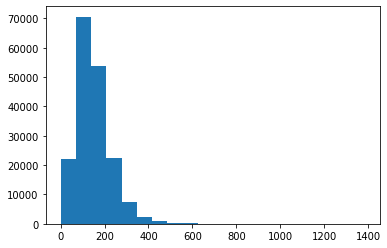

In [65]:
# visualize the avg_char_len 
plt.hist(char_len, bins=20);

In [66]:
# How long of a sentence length covers 95% of examples?
output_sen_len = int(np.percentile(char_len, 95))
output_sen_len

290

In [67]:
# Get all the keyboard character
alphabets = string.ascii_lowercase + string.digits + string.punctuation
alphabets

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### Text-vectorization layer for character level embeddings

In [68]:
# Setting the text-vectorizer
NUM_CHAR_TOKENS = len(alphabets) + 2 # add 2 for space and OOV token {OOV = out of vocab, '[UNK]'}
max_length = output_sen_len

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=max_length,
                                    standardize='lower_and_strip_punctuation',
                                    name="char_vectorizer")

In [69]:
# Adapt to our training characters
char_vectorizer.adapt(train_chars)

In [70]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"No. of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

No. of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [71]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}\n")
vectorized_train_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n{vectorized_train_chars}")
print(f"Length of vectorized_train_chars: {len(vectorized_train_chars[0])}")

Charified text:
t h e   m e d i a n   p r o g r e s s i o n - f r e e   s u r v i v a l   w a s   @   m o n t h s   i n   t h e   d o c e t a x e l   p l u s   s - @   g r o u p   a n d   @   m o n t h s   i n   t h e   s - @   a l o n e   g r o u p   (   p   =   @   )   .
Length of random_train_chars: 103

Vectorized chars:
[[ 3 13  2 15  2 10  4  5  6 14  8  7 18  8  2  9  9  4  7  6 17  8  2  2
   9 16  8 21  4 21  5 12 20  5  9 15  7  6  3 13  9  4  6  3 13  2 10  7
  11  2  3  5 24  2 12 14 12 16  9  9 18  8  7 16 14  5  6 10 15  7  6  3
  13  9  4  6  3 13  2  9  5 12  7  6  2 18  8  7 16 14 14  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0

#### Embeddings for character level tokenizer

In [72]:
# Creating an embedding layer
char_embedding = layers.Embedding(input_dim=len(char_vocab),  # no. of different characters
                                  output_dim=25,  # output shape
                                  mask_zero=True,  # use masking to handle variable sequence lengths
                                  name="char_embedding")
char_embedding

In [73]:
# Test out our embedding layer
print(f"Charified text:\n{random_train_chars}\n")
print(f"Length of charified text:\n{len(random_train_chars.split())}\n")
char_embed = char_embedding(char_vectorizer([random_train_chars]))
print(f"Embedding for charified text:\n{char_embed}\n")
print(f"Shape of embedding:\n{char_embed.shape}")

Charified text:
t h e   m e d i a n   p r o g r e s s i o n - f r e e   s u r v i v a l   w a s   @   m o n t h s   i n   t h e   d o c e t a x e l   p l u s   s - @   g r o u p   a n d   @   m o n t h s   i n   t h e   s - @   a l o n e   g r o u p   (   p   =   @   )   .

Length of charified text:
103

Embedding for charified text:
[[[ 0.01968035  0.03200621 -0.014497   ... -0.04865477  0.02683356
   -0.01401844]
  [-0.02940375 -0.00833941 -0.03042443 ...  0.04982737  0.04007535
   -0.00290019]
  [ 0.01184068  0.02092648  0.04443699 ...  0.00994083  0.01864574
    0.0317037 ]
  ...
  [ 0.0064263   0.0362254  -0.03173348 ... -0.0129232  -0.04637811
   -0.03834237]
  [ 0.0064263   0.0362254  -0.03173348 ... -0.0129232  -0.04637811
   -0.03834237]
  [ 0.0064263   0.0362254  -0.03173348 ... -0.0129232  -0.04637811
   -0.03834237]]]

Shape of embedding:
(1, 290, 25)


#### Creating the CNN

In [74]:
# Create the model for character level embeddings
input = layers.Input(shape=(1, ), dtype=tf.string)
x = char_vectorizer(input)
x = char_embedding(x)
x = layers.Conv1D(256,
                  kernel_size=3,
                  padding='same',
                  activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(input, output, name="conv_1d_char_embed")

In [75]:
model_3.summary()

Model: "conv_1d_char_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 256)          19456     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 5)          

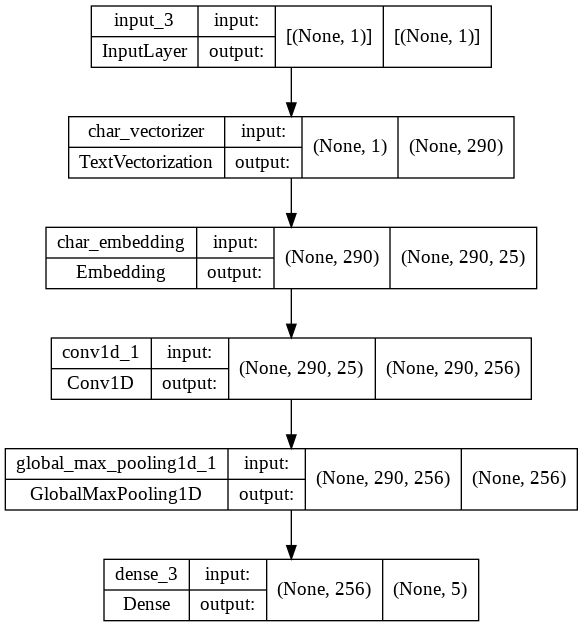

In [76]:
# Plot hybrid token and character model
plot_model(model_3, show_shapes=True)

In [77]:
# Create char level dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [78]:
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [79]:
# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=['accuracy'])

# Fit the model
model_3_history = model_3.fit(train_char_dataset,
                              validation_data=val_char_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 4s 7ms/step - loss: 1.2439 - accuracy: 0.4964 - val_loss: 1.0205 - val_accuracy: 0.6054
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 0.9995 - accuracy: 0.6010 - val_loss: 0.9259 - val_accuracy: 0.6403
Epoch 3/5
562/562 [==============================] - 4s 7ms/step - loss: 0.9314 - accuracy: 0.6336 - val_loss: 0.8896 - val_accuracy: 0.6489
Epoch 4/5
562/562 [==============================] - 4s 7ms/step - loss: 0.8798 - accuracy: 0.6558 - val_loss: 0.8332 - val_accuracy: 0.6779
Epoch 5/5
562/562 [==============================] - 4s 6ms/step - loss: 0.8582 - accuracy: 0.6686 - val_loss: 0.8265 - val_accuracy: 0.6918


In [80]:
# Evaluate the model 3
model_3.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 1.6988 - accuracy: 0.3847


[1.6988030672073364, 0.3846815824508667]

In [81]:
# Make predictions on the validation dataset
model_3_preds = model_3.predict(val_dataset)
model_3_preds[:10]

array([[0.24051194, 0.03810073, 0.5446938 , 0.02596014, 0.15073337],
       [0.15880203, 0.03137528, 0.67581654, 0.01729574, 0.11671039],
       [0.27419484, 0.03816601, 0.52648985, 0.02889433, 0.13225497],
       [0.24051194, 0.03810073, 0.5446938 , 0.02596014, 0.15073337],
       [0.24051194, 0.03810073, 0.5446938 , 0.02596014, 0.15073337],
       [0.15880203, 0.03137528, 0.67581654, 0.01729574, 0.11671039],
       [0.15880203, 0.03137528, 0.67581654, 0.01729574, 0.11671039],
       [0.15880203, 0.03137528, 0.67581654, 0.01729574, 0.11671039],
       [0.15880203, 0.03137528, 0.67581654, 0.01729574, 0.11671039],
       [0.24051194, 0.03810073, 0.5446938 , 0.02596014, 0.15073337]],
      dtype=float32)

In [82]:
# Converting the pred probs to labels
model_3_preds = tf.argmax(model_3_preds, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 2, 2, ..., 2, 2, 2])>

In [83]:
# Calculating the evaluation metrics for model 3
model_3_result = calculate_results(y_true=val_labels,
                                  y_pred=model_3_preds)
model_3_result

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 38.468158347676415,
 'precision': 0.4297148625509117,
 'recall': 0.3846815834767642,
 'f1': 0.2971602464750902}

### Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`).
2. Create a character level model (similar to `model_3` with a slight modification).
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`).
4. Build a series of output layers on top of 3 similar to Figure 1.
5. Construct a model which takes tokens and character-level sequences as input and produces sequence label probabilites as output.

In [84]:
# 1. Setup model for token-level embeddings
token_input = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embedding = tf_hub_embedding_layer(token_input)
token_output = layers.Dense(300, activation="relu")(token_embedding)
token_model = tf.keras.Model(token_input, token_output)

# 2. Setup model for character-level embeddings
char_input = layers.Input(shape=(1, ), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_input)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_input, char_bi_lstm)

# 3. Combine token and character-level embedding model
token_char_concatenate = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                       char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concatenate)
combined_dense = layers.Dense(300, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_input, char_input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [85]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 univeral_sentence_encoder (Ker  (None, 512)         256797824   [

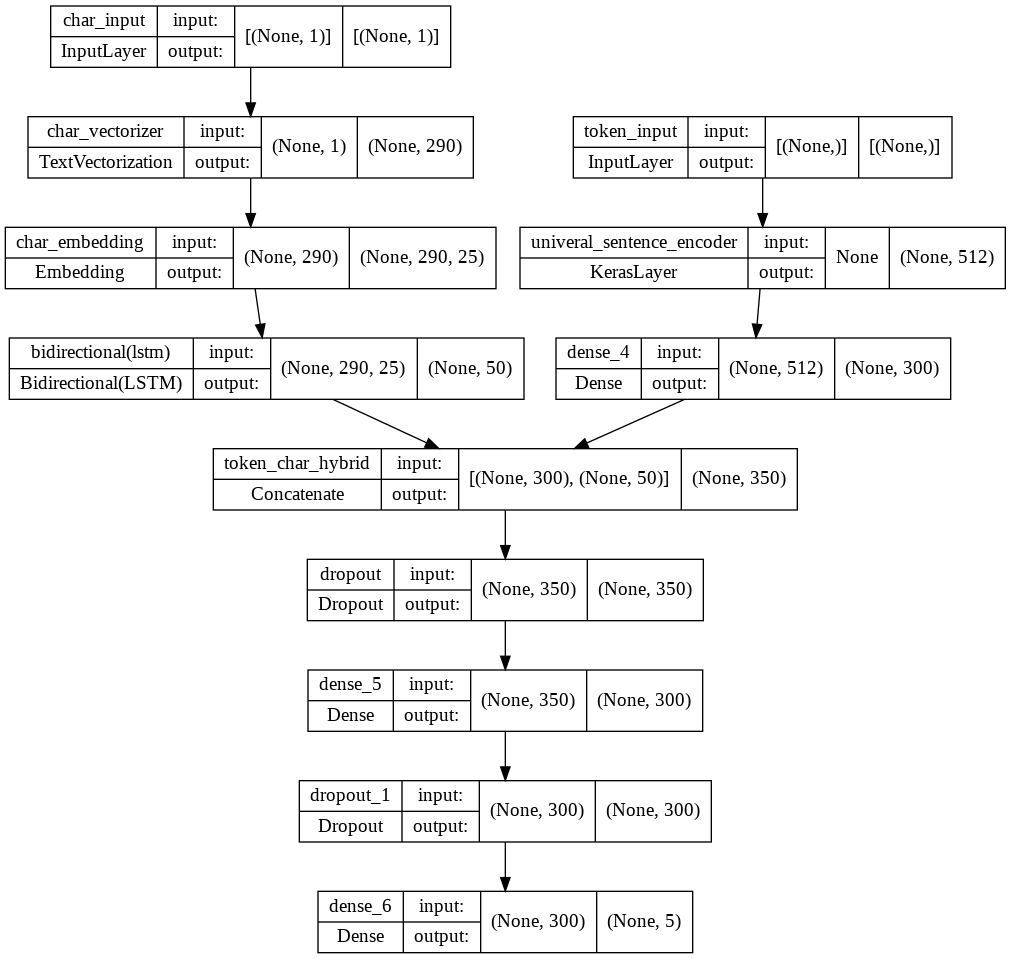

In [86]:
# Plot hybrid token and character model
plot_model(model_4, show_shapes=True)

#### Compiling the hybrid model

In [87]:
# compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer='Adam',
                metrics=['accuracy'])

#### Creating datasets for hybrid model training and prediction

In [88]:
# Create chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train dataset
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [89]:
# Create chars and tokens into a dataset for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# Prefetch and batch train dataset
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#### Fitting the hybrid model

In [90]:
# fit the model
model_4_history = model_4.fit(train_char_token_dataset,
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              steps_per_epoch=int(0.1*len(val_char_token_dataset)),
                              validation_steps=int(0.1*len(train_char_token_dataset)))

Epoch 1/5
94/94 [==============================] - 27s 198ms/step - loss: 1.1963 - accuracy: 0.5206 - val_loss: 0.9130 - val_accuracy: 0.6346
Epoch 2/5
94/94 [==============================] - 18s 195ms/step - loss: 0.9567 - accuracy: 0.6213 - val_loss: 0.8313 - val_accuracy: 0.6825
Epoch 3/5
94/94 [==============================] - 17s 181ms/step - loss: 0.9008 - accuracy: 0.6406 - val_loss: 0.7909 - val_accuracy: 0.6914
Epoch 4/5
94/94 [==============================] - 17s 180ms/step - loss: 0.8191 - accuracy: 0.6845 - val_loss: 0.7587 - val_accuracy: 0.7074
Epoch 5/5
94/94 [==============================] - 17s 179ms/step - loss: 0.7940 - accuracy: 0.6922 - val_loss: 0.7424 - val_accuracy: 0.7149


In [91]:
# Evaluate the model
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 23s 24ms/step - loss: 0.7496 - accuracy: 0.7125


[0.7496033310890198, 0.7124983668327332]

In [92]:
# Make predictions on the validation dataset
model_4_preds = model_4.predict(val_char_token_dataset)
model_4_preds

array([[4.1572464e-01, 3.9843938e-01, 1.7077198e-02, 1.4831887e-01,
        2.0439904e-02],
       [3.8126183e-01, 4.9786824e-01, 1.1101344e-02, 1.0208652e-01,
        7.6820524e-03],
       [2.3384765e-01, 2.0273171e-01, 3.5048958e-02, 4.9436665e-01,
        3.4005146e-02],
       ...,
       [5.0345750e-04, 5.6941509e-03, 3.2503348e-02, 1.9793939e-04,
        9.6110111e-01],
       [7.3339930e-03, 3.3286761e-02, 4.0043312e-01, 1.4805890e-03,
        5.5746555e-01],
       [1.5215479e-01, 1.7000912e-01, 6.0089946e-01, 5.4198843e-03,
        7.1516730e-02]], dtype=float32)

In [93]:
# converting the pred probs to labels
model_4_preds = tf.argmax(model_4_preds, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [94]:
# Performance metrics for model_4
model_4_results = calculate_results(y_true=val_labels,
                                   y_pred=model_4_preds)
model_4_results

{'accuracy': 71.24983450284655,
 'precision': 0.712182288083032,
 'recall': 0.7124983450284655,
 'f1': 0.7060006914635278}

### Model 5: Builiding a tribrid embedding model

1. Create a token-level embedding model
2. Create a character-level embedding model
3. Create a model for 'line_number' feature
4. Create a model for 'total_lines' feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs into a tf.keras.Model

##### Analysing line numbers

In [95]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [96]:
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

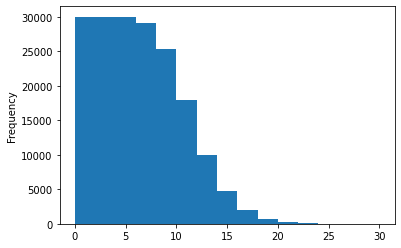

In [97]:
train_df['line_number'].plot.hist(bins=15);

Most of the lines have been covered upto 15 length.

In [98]:
# One-hot encode the line numbers
train_line_numbers = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

In [99]:
train_line_numbers[:10]

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

#### Analysing the total no. of lines

In [100]:
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

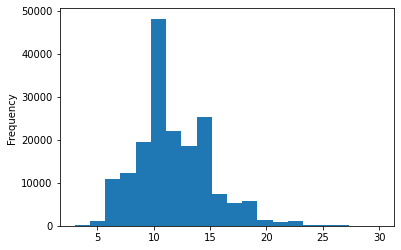

In [101]:
# Let's visualize the total no. of lines
train_df['total_lines'].plot.hist(bins=20)

In [102]:
# What length of lines covers the 95% of total_lines?
np.percentile(train_df['total_lines'], 95)

18.0

In [103]:
# One-hot encode the total no. of lines
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

In [104]:
train_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

In [105]:
# 1. Token inputs
token_inputs = layers.Input([], dtype='string', name='token_inputs')
token_embedding = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embedding)
token_model = tf.keras.Model(token_inputs, token_output)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_output = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_output)

# 3. Model for line_number
line_number_inputs = layers.Input(shape=(15, ), dtype=tf.float32, name='line_number_inputs')
x = layers.Dense(64, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Model for total lines
total_lines_inputs = layers.Input(shape=(20, ), dtype=tf.int32, name='total_lines_inputs')
x = layers.Dense(64, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, x)

# 5. Concatenate the outputs of 1 & 2
token_char_concatenate = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                       char_model.output])

z = layers.Dense(256, activation="relu")(token_char_concatenate)
z = layers.Dropout(0.5)(z)

# 6. Concatenate the outputs of 3, 4, 5
token_char_lines_concatenate = layers.Concatenate(name="token_char_lines_hybrid")([line_number_model.output,
                                                                                   total_lines_model.output,
                                                                                   z])

# 7. Create output layers - adding in Dropout
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(token_char_lines_concatenate)

# 8. Construct model with char and token inputs
model_5 = tf.keras.Model(inputs=[line_number_model.inputs, 
                                 total_lines_model.inputs,
                                 token_model.inputs, 
                                 char_model.inputs],
                         outputs=output_layer,
                         name="model_5_tribrid_embeddings")

In [106]:
# summarz of tribrid model
model_5.summary()

Model: "model_5_tribrid_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 univeral_sentence_encoder (Ker  (None, 512)         256797824   ['token_

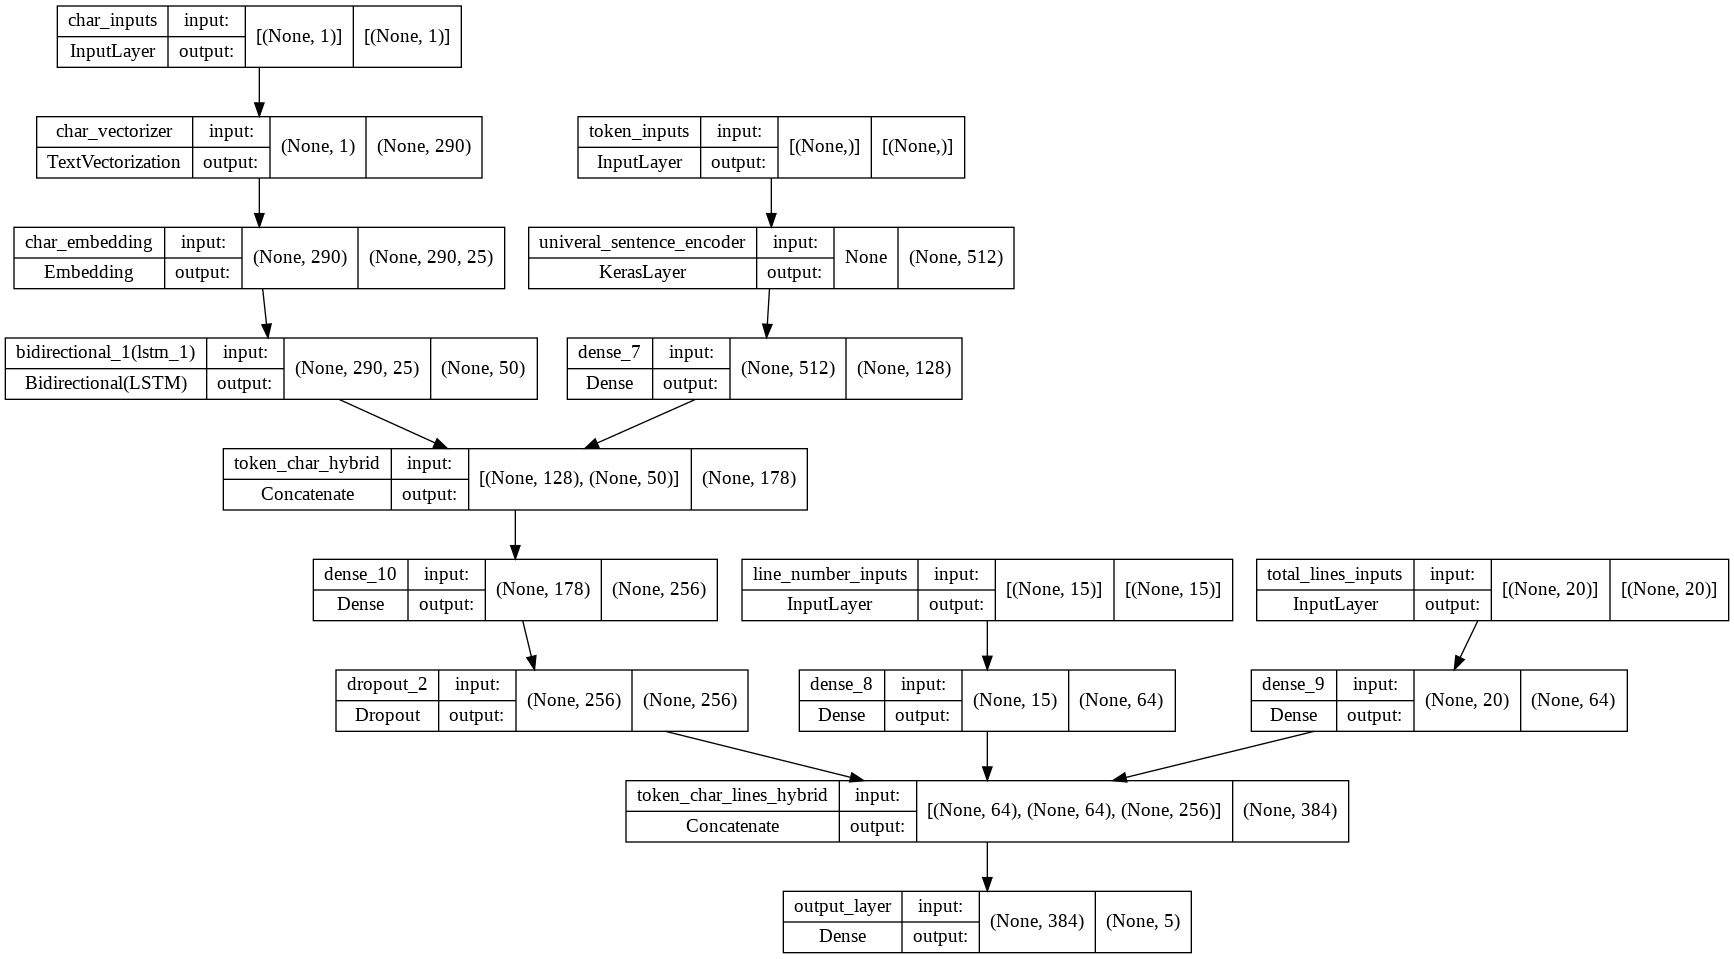

In [107]:
# Plot the tribrid model
plot_model(model_5, show_shapes=True)

In [108]:
# Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer='Adam',
                metrics=['accuracy'])

#### Creating datasets for training, validation and testing

In [109]:
## Training Dataset

# Create chars and tokens into a dataset
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_numbers, train_total_lines_one_hot, train_sentences, train_chars))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels))

# Prefetch and batch train dataset
train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Validation Dataset

# Create chars and tokens into a dataset
val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_numbers, val_total_lines_one_hot, val_sentences, val_chars))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels))

# Prefetch and batch val dataset
val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_tribrid_dataset, val_tribrid_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

#### Fitting, Evaluating and making predictions with our hybrid model

In [110]:
# Fit the model
model_5_history = model_5.fit(train_tribrid_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_tribrid_dataset)),
                              validation_data=val_tribrid_dataset,
                              validation_steps=int(0.1*len(val_tribrid_dataset)))

Epoch 1/5
562/562 [==============================] - 40s 57ms/step - loss: 1.0797 - accuracy: 0.7335 - val_loss: 0.9738 - val_accuracy: 0.8039
Epoch 2/5
562/562 [==============================] - 29s 51ms/step - loss: 0.9624 - accuracy: 0.8178 - val_loss: 0.9448 - val_accuracy: 0.8291
Epoch 3/5
562/562 [==============================] - 27s 48ms/step - loss: 0.9471 - accuracy: 0.8263 - val_loss: 0.9358 - val_accuracy: 0.8331
Epoch 4/5
562/562 [==============================] - 30s 53ms/step - loss: 0.9377 - accuracy: 0.8373 - val_loss: 0.9296 - val_accuracy: 0.8324
Epoch 5/5
562/562 [==============================] - 28s 50ms/step - loss: 0.9352 - accuracy: 0.8402 - val_loss: 0.9218 - val_accuracy: 0.8431


In [123]:
# make predictions with the char token pos model
model_5_preds = model_5.predict(val_tribrid_dataset)
model_5_preds

array([[0.594435  , 0.08481752, 0.0179088 , 0.27414328, 0.0286955 ],
       [0.64962894, 0.07787615, 0.08306116, 0.17938058, 0.01005309],
       [0.33004522, 0.10779835, 0.12873466, 0.37795702, 0.05546476],
       ...,
       [0.03541339, 0.06226746, 0.03407728, 0.03181662, 0.8364253 ],
       [0.02145144, 0.3124104 , 0.11870766, 0.02217769, 0.5252528 ],
       [0.10309527, 0.7098809 , 0.06851734, 0.02318563, 0.09532084]],
      dtype=float32)

In [124]:
# convert pred probs to labels
model_5_preds = tf.argmax(model_5_preds, axis=1)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [125]:
# Performance metrics for model 5
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)

## Comparing model results

In [126]:
# Combine model results into a dataframe
results = pd.DataFrame({"baseline_Naive_bayes": baseline_result,
                        "model_1_custom_token_embedding": model_1_results,
                        "model_2_pretrained_token_embedding": model_2_results,
                        "model_3_custom_char_embedding": model_3_result,
                        "model_4_hybrid_char_token_embedding": model_4_results,
                        "model_5_pos_char_token_embedding": model_5_results})
results = results.transpose()
results

,accuracy,precision,recall,f1
baseline_Naive_bayes,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,81.778763,0.819718,0.817788,0.815472
model_2_pretrained_token_embedding,74.321462,0.739248,0.743215,0.737502
model_3_custom_char_embedding,38.468158,0.429715,0.384682,0.297160
model_4_hybrid_char_token_embedding,71.249835,0.712182,0.712498,0.706001
model_5_pos_char_token_embedding,84.304250,0.845241,0.843042,0.839525


In [127]:
# Reduce the accuracy to same scale as the other metrics
results['accuracy']/=100

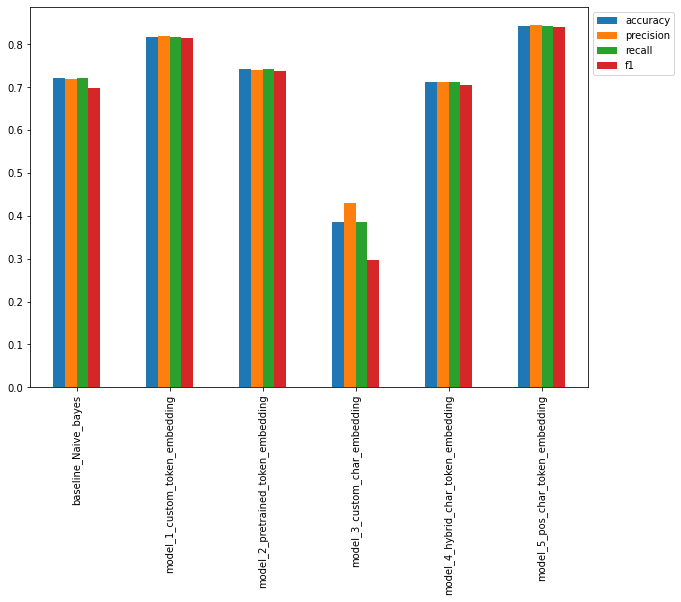

In [128]:
# Plot and compare all model results
results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1, 1))

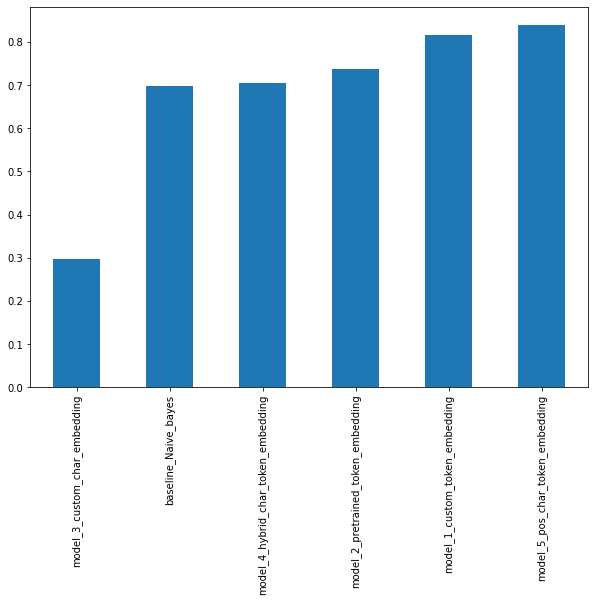

In [129]:
# sort model results by f1-score
results.sort_values("f1", ascending=True)['f1'].plot(kind='bar', figsize=(10, 7))

## Save and load the model

In [130]:
model_5.save("skimlit_token_char_pos_embedding")

In [132]:
# Load the saved model
model_5_load = tf.keras.models.load_model("skimlit_token_char_pos_embedding")
model_5_load

In [ ]:
# make predictions with the loaded model on the validation set
loaded_pred_probs = model_5_load.predict(val_tribrid_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

In [133]:
# Performance metrics for loaded model
loaded_model_results = calculate_results(y_true=val_labels,
                                         y_pred=loaded_preds)
loaded_model_results

{'accuracy': 84.30424996690057,
 'precision': 0.845241382980853,
 'recall': 0.8430424996690057,
 'f1': 0.8395253910348658}

In [134]:
# Actual model results
model_5_results

{'accuracy': 84.30424996690057,
 'precision': 0.845241382980853,
 'recall': 0.8430424996690057,
 'f1': 0.8395253910348658}